# AMV in FOCI-OpenIFS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43443 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:42819 Dashboard: http://127.0.0.1:43443/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [6]:
#exp_list = ['focioifs-merge14']
#exp_list = ['FOCI_GJK001','FOCI_NJK007','FOCI_NJK007_cont3']
#time_list = [slice('1850-01-01','3000-01-01'), slice('1850-01-01','2300-01-01'),slice('2300-01-01','3000-01-01')]

#exp_list = ['FOCI_GJK001','foci-cpl-06']
#time_list = [slice('1850-01-01','3000-01-01'),slice('1850-01-01','3150-01-01')]

#exp_list = ['foci-test-05','foci-test-07']
#time_list = [slice('1850-01-01','1960-01-01'),slice('1850-01-01','1960-01-01')]

# Old continuation that did not work
#exp_list = ['FOCI_GJK001','FOCI_GJK001_cont']
#time_list = [slice('1850-01-01','3000-01-01'),slice('3000-01-01','3200-01-01')]

exp_list = ['FOCI_GJK001','FOCI_GJK006']
time_list = [slice('1850-01-01','2850-01-01'),slice('2850-01-01','4000-01-01')]

In [7]:
# OpenIFS surface
ds_sfc_all = []
for exp,time in zip(exp_list,time_list):
    if exp == 'FOCI_NJK007':
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir2,exp)
    else:
        sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*regular_sfc.nc


In [8]:
ds_sfc_full = xr.concat(ds_sfc_all, compat='equals', dim='time')
ds_sfc_full

<xarray.Dataset>
Dimensions:            (bnds: 2, lat: 96, lon: 192, time: 2100)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 3949-07-01 06:00:00
  * lon                (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * lat                (lat) float32 -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
Dimensions without coordinates: bnds
Data variables: (12/42)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(10, 2), meta=np.ndarray>
    sstk               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ci                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    es                 (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tclw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    tciw               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ...                 ...
    swvl1              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl2              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl3              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    swvl4              (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    sro                (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
    ssro               (time, lat, lon) float32 dask.array<chunksize=(10, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Mon Nov 22 19:25:50 2021: ncks -O -7 --no-alphabetize -L 1 ...
    Conventions:  CF-1.6
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2021-Nov-12 19:21:56 GMT
    uuid:         0c810368-fe66-48aa-9163-86fa3ed8dac8
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [9]:
def wgtm(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    wgt = data.weighted(weights)
    mean = wgt.mean(('lon','lat'))
    return mean

def amv(sst):
    lon1 = 290
    lon2 = 360
    lat1 = 40
    lat2 = 70
    amv = wgtm( sst.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)) )
    return amv

In [10]:
amv_all = []

if 1:
    
    # Compute AMV index
    amv_raw = amv(ds_sfc_full['sstk']).compute()
    
    # Annual
    amv_y = amv_raw.groupby('time.year').mean('time')
    amv_index = amv_y - amv_y.mean('year')
    
    # 10-year running mean
    amv_run = amv_index.rolling(year=11,center=True).mean()
    
    amv_all.append(amv_run)

No handles with labels found to put in legend.


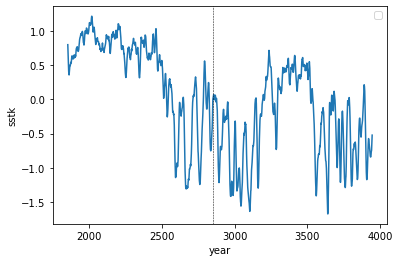

In [11]:
fig1, ax1 = plt.subplots(1,1)

for i, (amv, exp) in enumerate( zip(amv_all, exp_list) ):
    
    #ax1.plot(amv, label=exp)
    amv.plot(ax=ax1)
    
ax1.axvline(x=2850, c='k', lw=0.5, linestyle='--')
ax1.legend()

fig1.savefig('plots/amv_full.pdf',format='pdf')